In [39]:
%run Module-2-helper.py

# Decision Tree 
---

In [40]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT = './simulated-data-transformed' 

BEGIN_DATE = "2022-01-15"
END_DATE = "2022-04-20"

print("Load  files")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.Trans_FRAUD.sum()))

output_feature = "Trans_FRAUD"

input_features = ['Trans_AMOUNT','Trans_DURING_WEEKEND', 'Trans_DURING_NIGHT', 'CUSTOMER_ID_NB_Trans_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'STORE_ID_NB_Trans_1DAY_WINDOW',
       'STORE_ID_RISK_1DAY_WINDOW', 'STORE_ID_NB_Trans_7DAY_WINDOW',
       'STORE_ID_RISK_7DAY_WINDOW', 'STORE_ID_NB_Trans_30DAY_WINDOW',
       'STORE_ID_RISK_30DAY_WINDOW']

Load  files
2323689 transactions loaded, containing 10132 fraudulent transactions


In [41]:
# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2022-02-28", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)


In [42]:
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'Trans_FRAUD','Trans_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }


In [43]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df


In [44]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.760550,0.007122,0.419822,0.015840,0.381429,0.024702,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.440953,0.779055,0.006532,0.464257,0.007255,0.402857,0.018406,2
1,0.767051,0.009392,0.489381,0.011747,0.388214,0.029904,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.524904,0.784937,0.006387,0.530790,0.013025,0.412143,0.019312,3
2,0.773661,0.007533,0.516642,0.016120,0.399286,0.025405,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.606925,0.785644,0.007255,0.557105,0.019200,0.409286,0.023765,4
3,0.774974,0.008803,0.523959,0.016756,0.400000,0.022338,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.692533,0.785504,0.005777,0.553309,0.013548,0.405714,0.017113,5
4,0.767819,0.011742,0.522342,0.015627,0.401071,0.021294,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.781745,0.783250,0.003844,0.519537,0.051682,0.404643,0.015131,6
5,0.754036,0.005699,0.501578,0.020609,0.392500,0.025483,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.869211,0.780377,0.006730,0.509614,0.045779,0.399643,0.015266,7
6,0.746190,0.003101,0.484691,0.015561,0.384643,0.029231,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.951274,0.766523,0.018691,0.505938,0.050618,0.397500,0.015984,8
7,0.739451,0.006154,0.481737,0.020485,0.383929,0.028165,"{'clf__max_depth': 9, 'clf__random_state': 0}",1.033662,0.773066,0.028506,0.486591,0.060649,0.395714,0.017409,9
8,0.734358,0.014654,0.479437,0.017484,0.383214,0.027131,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.114933,0.769319,0.030731,0.498958,0.039274,0.395000,0.016918,10
9,0.757598,0.016951,0.390405,0.027716,0.382500,0.026848,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.801951,0.768372,0.016163,0.392702,0.037631,0.396786,0.018962,20


In [45]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,4,4,3
Validation performance,0.786+/-0.01,0.557+/-0.02,0.412+/-0.02
Test performance,0.774+/-0.01,0.517+/-0.02,0.388+/-0.03
Optimal parameters,5,5,6
Optimal test performance,0.775+/-0.01,0.524+/-0.02,0.401+/-0.02


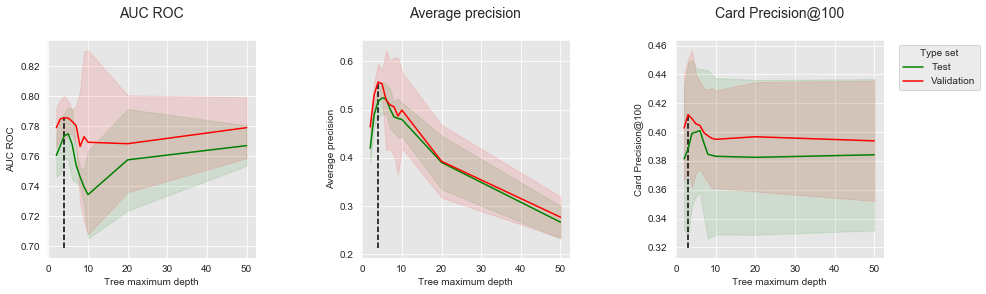

In [46]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

# Logistic Regression 
---

In [47]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,20, 30, 49, 50,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [48]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.789638,0.006668,0.425644,0.012453,0.384286,0.021500,"{'clf__C': 0.1, 'clf__random_state': 0}",0.790501,0.812262,0.008426,0.445994,0.021123,0.397500,0.018333,0.1
1,0.790546,0.006407,0.429357,0.011668,0.382500,0.021955,"{'clf__C': 1, 'clf__random_state': 0}",0.939908,0.813071,0.008763,0.449192,0.021692,0.394643,0.018165,1.0
2,0.790646,0.006389,0.429687,0.011492,0.381429,0.020874,"{'clf__C': 10, 'clf__random_state': 0}",0.840581,0.813170,0.008812,0.449456,0.021711,0.394286,0.018708,10.0
3,0.790651,0.006384,0.429713,0.011486,0.381429,0.020874,"{'clf__C': 20, 'clf__random_state': 0}",0.827045,0.813176,0.008814,0.449470,0.021714,0.394286,0.018708,20.0
4,0.790655,0.006385,0.429726,0.011471,0.381429,0.020874,"{'clf__C': 30, 'clf__random_state': 0}",0.842565,0.813180,0.008817,0.449462,0.021724,0.394286,0.018708,30.0
5,0.790657,0.006385,0.429730,0.011466,0.381429,0.020874,"{'clf__C': 49, 'clf__random_state': 0}",0.778763,0.813180,0.008819,0.449468,0.021727,0.394286,0.018708,49.0
6,0.790656,0.006385,0.429733,0.011464,0.381429,0.020874,"{'clf__C': 50, 'clf__random_state': 0}",0.783719,0.813180,0.008816,0.449476,0.021728,0.394286,0.018708,50.0
7,0.790657,0.006385,0.429737,0.011456,0.381429,0.020874,"{'clf__C': 100, 'clf__random_state': 0}",0.719464,0.813180,0.008816,0.449473,0.021718,0.394286,0.018708,100.0


In [49]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,49.0,50.0,0.1
Validation performance,0.813+/-0.01,0.449+/-0.02,0.397+/-0.02
Test performance,0.791+/-0.01,0.43+/-0.01,0.384+/-0.02
Optimal parameters,49.0,100.0,0.1
Optimal test performance,0.791+/-0.01,0.43+/-0.01,0.384+/-0.02


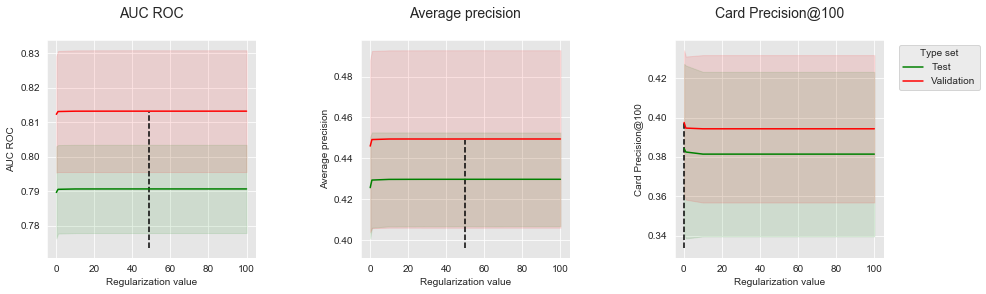

In [50]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)

# Random Forest
---

In [51]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_6906/3009023478.py", line 9, in <cell line: 9>
    performances_df=model_selection_wrapper(transactions_df, classifier,
  File "/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py", line 271, in model_selection_wrapper
    # Get performances on the validation set using prequential validation
  File "/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py", line 242, in prequential_grid_search
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 875, in fit
    self._run_search(evaluate_candidates)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/

In [ ]:
performances_df_rf

In [ ]:
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

In [ ]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

In [ ]:
performances_df_rf_fixed_max_tree_depth=performances_df_rf[performances_df_rf["Parameters summary"].str.endswith("20")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_rf_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

In [ ]:
get_execution_times_plot(performances_df_rf_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Maximum tree depth")

In [ ]:
get_execution_times_plot(performances_df_rf_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Maximum tree depth")

In [ ]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_rf,2))+"s")

# XGBoosting
---

In [ ]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3,6,9], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.1, 0.3],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [ ]:
performances_df_xgboost

In [ ]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

In [ ]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.3")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

In [ ]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.3/3")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

In [ ]:
get_execution_times_plot(performances_df_xgboost_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

In [ ]:
get_execution_times_plot(performances_df_xgboost_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

In [ ]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_boosting,2))+"s")

# Comparison Between Models
---

In [ ]:
performances_df_dictionary={
    "Decision Tree": performances_df_dt,
    "Logistic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [ ]:
model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

In [ ]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'])
    

In [ ]:
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]


In [ ]:
%%capture

fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=['Decision Tree','Logistic Regression','Random Forest','XGBoost']
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
    
# Create execution times bars
ax.bar(r1, execution_times[0:4], 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)


In [ ]:
fig_model_selection_execution_times_for_each_model_class